#### What is outlier detetection?

Outlier detection, also known as anomaly detection, refers to the identification of rare
items, events or observations which differ from the general distribution of a population[1]. 

An outlier is an observation that appears to deviate markedly from other observations in the sample[2].

###### Why is this important?
- An outlier may indicate bad data. For example, the data may have been coded incorrectly or an experiment may not have been run correctly.
-  Outliers may be due to random variation or may indicate something scientifically interesting[2].
- Outliers can impact the results of our analysis and statistical modeling in a drastic way. It  can for instance skew the average significantly.

Outlier detection also has many practical use cases. The most famous examples include the detection of (financial) fraud and the detection of ‘malicious’ chatter by intelligence agencies[3]

![Outliers.jpeg](attachment:Outliers.jpg)

There are many ways of detecting outliers and anomaly in a data with the crudest method being visualization. 

Howeever, we'll be lloking at how to use PyOD in detetcing outliers in our data

PyOD is a comprehensive and scalable Python toolkit for detecting outlying objects in multivariate data.

PyOD has several advantages and comes with quite a few useful features. for instance: 
- Open Source with detailed documentation and examples across various algorithms
- Supports advanced models, including Neural Networks, Deep Learning, and Outlier Ensembles
- Compatible with both Python 2 & 3

##### Installing PyOD in Python


In [1]:
#!pip install pyod
#!pip install --upgrade pyod  
#!pip install combo
# to make sure that the latest version is installed!

PyOD has several outrlier detection algorithms 

1. Angle-Based Outlier Detection (ABOD)
- It considers the relationship between each point and its neighbor(s). It does not consider the relationships among these neighbors. The variance of its weighted cosine scores to all neighbors could be viewed as the outlying score
- ABOD performs well on multi-dimensional data

2. k-Nearest Neighbors Detector
- For any data point, the distance to its kth nearest neighbor could be viewed as the outlying score
- PyOD supports three kNN detectors:
    Largest: Uses the distance of the kth neighbor as the outlier score
    Mean: Uses the average of all k neighbors as the outlier score
    Median: Uses the median of the distance to k neighbors as the outlier score
    
3. Isolation Forest
- It uses the scikit-learn library internally. In this method, data partitioning is done using a set of trees. Isolation Forest provides an anomaly score looking at how isolated the point is in the structure. The anomaly score is then used to identify outliers from normal observations
- Isolation Forest performs well on multi-dimensional data

4. Histogram-based Outlier Detection
- It is an efficient unsupervised method which assumes the feature independence and calculates the outlier score by building histograms
- It is much faster than multivariate approaches, but at the cost of less precision

5. Local Correlation Integral (LOCI)
6. Feature Bagging
7. Clustering Based Local Outlier Factor

##### Implementation of PyOD

PyOD has a fucntion 'generate data' that we can use to generate dataset and practice on. 

we'll be using this and a real world dataset to detect outliers. 

#### PyOD on a Simulated Dataset
First, let’s import the required libraries:

In [108]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

let's use ABOD (Angle Based Outlier Detector) and KNN (K Nearest Neighbors) to detect ouliers here. 

In [109]:
# import the outlier detection models

from pyod.models.abod import ABOD
from pyod.models.knn import KNN

Now, we will create a random dataset with outliers and plot it.

In [4]:
from pyod.utils.data import generate_data, get_outliers_inliers

#generate random data with two features
X_train, Y_train = generate_data(n_train=200,train_only=True, n_features=2)

# by default the outlier fraction is 0.1 in generated data function 
outlier_fraction = 0.1

In [5]:
# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train,Y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

Text(0, 0.5, 'F2')

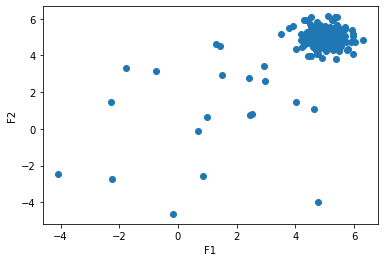

In [6]:
#separate the two features and use it to plot the data 
F1 = X_train[:,[0]].reshape(-1,1)
F2 = X_train[:,[1]].reshape(-1,1)

# create a meshgrid 
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))

# scatter plot 
plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2') 

In [7]:
#Create a dictionary and add all the models that you want to use to detect the outliers:

classifiers = {
     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
     'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}

Now let's fit the data to each outlier model and see how they perform 

No of Errors :  Angle-based Outlier Detector (ABOD) 4
No of Errors :  K Nearest Neighbors (KNN) 0


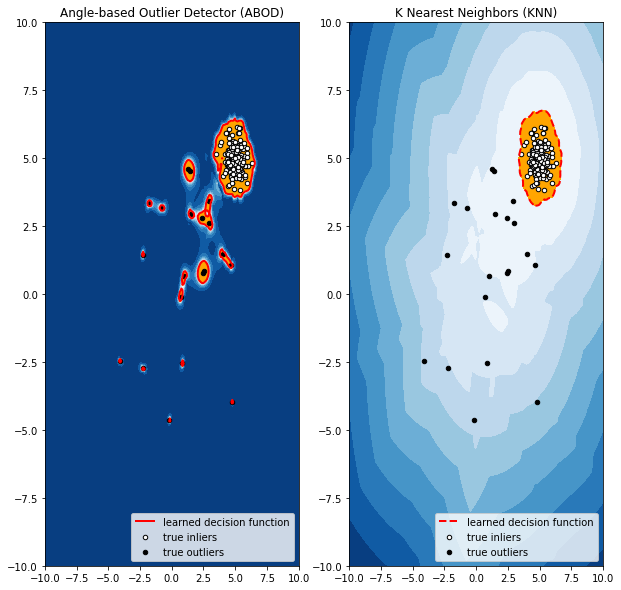

In [8]:
#set the figure size
plt.figure(figsize=(10, 10))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)
    
    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)
    
    # no of errors in prediction
    n_errors = (y_pred != Y_train).sum()
    print('No of Errors : ',clf_name, n_errors)
    
    #Now let's visualize
    
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

    subplot.set_title(clf_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show() 
    
    

#### Let's try an actual dataset

In [127]:
# import

from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF

In [128]:
#import and split dataset to test and train
import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [130]:
df['Item_MRP'].fillna(int(df['Item_MRP'].mean()), inplace=True)
df['Item_Outlet_Sales'].fillna(int(df['Item_Outlet_Sales'].mean()), inplace=True)

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Item_MRP'>

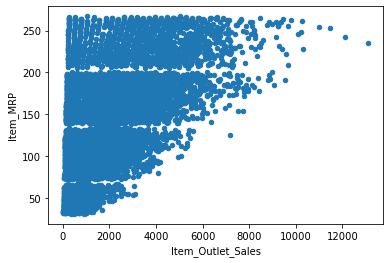

In [131]:
df.plot.scatter('Item_Outlet_Sales','Item_MRP')

In [132]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(df[['Item_MRP','Item_Outlet_Sales']])
df[['Item_MRP','Item_Outlet_Sales']].head()

,Item_MRP,Item_Outlet_Sales
0,0.927507,0.283587
1,0.072068,0.031419
2,0.468288,0.158115
3,0.640093,0.053555
4,0.095805,0.073651


In [133]:
X1 = df['Item_MRP'].values.reshape(-1,1)
X2 = df['Item_Outlet_Sales'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

In [134]:
# let's set the outlier percentage to be say 5%. This is a fxn of whatever we are trying to do or our understanding of the data
outliers_fraction= 0.05
random_state = np.random.RandomState(42) #random state can be anything 

#like we did above I will try this using diffrent OD tools
#Puttig the tools in a library 
classifiers = {
     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
     'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}



OUTLIERS :  857 INLIERS :  7666 Angle-based Outlier Detector (ABOD)


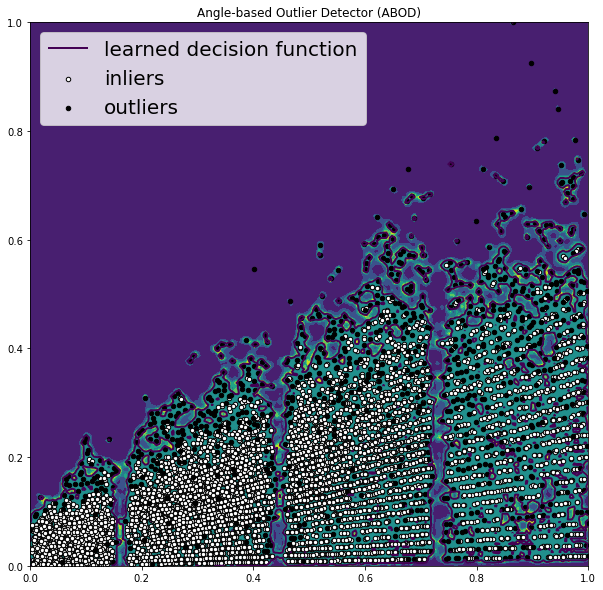

OUTLIERS :  427 INLIERS :  8096 Cluster-based Local Outlier Factor (CBLOF)


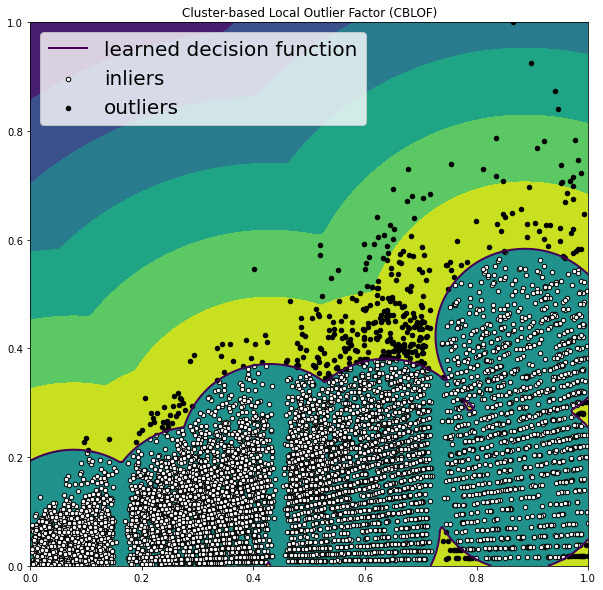

OUTLIERS :  612 INLIERS :  7911 K Nearest Neighbors (KNN)


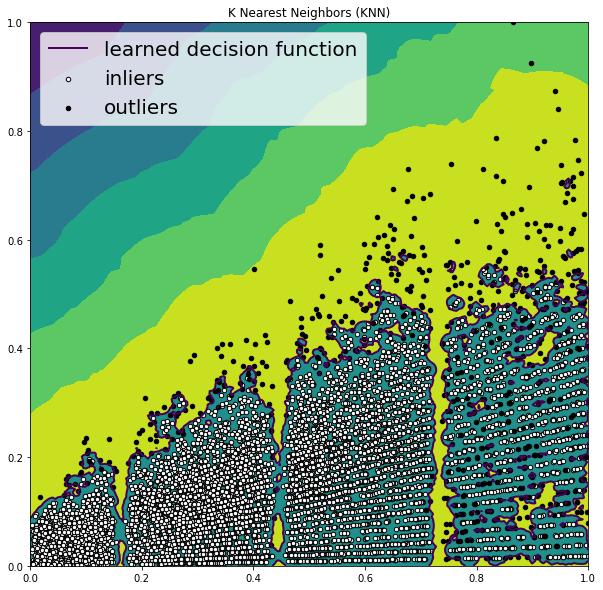

In [138]:
#let's create a meshgrid
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

#now we iterate through the OD clasifiers 
for i, (clf_name, clf) in enumerate(classifiers.items()):
    #fit
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # is it an inlier or not
    y_pred = clf.predict(X)
    #lets count the outliers and inliers
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # let's separate the outliers and inliers
    IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)
    
    OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # we need a threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill the colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7))
        
    # draw a line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2)
        
    # fill the lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()])
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

##### Refrences
[1] PyOD: A Python Toolbox for Scalable Outlier Detection by Yue Zhao zhaoy@cmu.edu
Zain Nasrullah znasrullah@cs.toronto.edu and Zheng Li jk zhengli@hotmail.com in Journal of Machine Learning Research 20 (2019) 1-7

[2] https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm

[3]  https://www.bigdataframework.org/the-importance-of-outlier-detection-in-big-data/

Codes modified from analyticsVidhya 